Structured data classification from scratch
Binary classification of structured data including numerical and categorical features.
Introduction
This example demonstrates how to do structured data classification, starting from a raw CSV file. Our data includes both numerical and categorical features. We will use Keras preprocessing layers to normalize the numerical features and vectorize the categorical ones.

Note that this example should be run with TensorFlow 2.3 or higher, or tf-nightly.

The dataset
Our dataset is provided by the Cleveland Clinic Foundation for Heart Disease. It's a CSV file with 303 rows. Each row contains information about a patient (a sample), and each column describes an attribute of the patient (a feature). We use the features to predict whether a patient has a heart disease (binary classification).

Here's the description of each feature:

Column	Description	Feature Type
Age	Age in years	Numerical
Sex	(1 = male; 0 = female)	Categorical
CP	Chest pain type (0, 1, 2, 3, 4)	Categorical
Trestbpd	Resting blood pressure (in mm Hg on admission)	Numerical
Chol	Serum cholesterol in mg/dl	Numerical
FBS	fasting blood sugar in 120 mg/dl (1 = true; 0 = false)	Categorical
RestECG	Resting electrocardiogram results (0, 1, 2)	Categorical
Thalach	Maximum heart rate achieved	Numerical
Exang	Exercise induced angina (1 = yes; 0 = no)	Categorical
Oldpeak	ST depression induced by exercise relative to rest	Numerical
Slope	Slope of the peak exercise ST segment	Numerical
CA	Number of major vessels (0-3) colored by fluoroscopy	Both numerical & categorical
Thal	3 = normal; 6 = fixed defect; 7 = reversible defect	Categorical
Target	Diagnosis of heart disease (1 = true; 0 = false)	Target

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#Preparing the data
file_url = "https://storage.googleapis.com/applied-dl/heart.csv"
dataframe = pd.read_csv(file_url)
print(dataframe.shape)
dataframe.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [3]:
#The last column, "target", indicates whether the patient has a heart disease (1) or not (0).
#Let's split the data into a training and validation set:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


In [4]:
#Let's generate tf.data.Dataset objects for each dataframe:

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

print(type(train_ds))
print(len(list(train_ds.as_numpy_iterator())))
print(len(list(train_ds)))
#Each Dataset yields a tuple (input, target) where input is a dictionary of features and target is the value 0 or 1:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

<class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>
242
242
Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=66>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=160>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=228>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=138>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.3>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'fixed'>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [5]:
#Let's batch the datasets:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

Feature preprocessing with Keras layers
The following features are categorical features encoded as integers:

sex
cp
fbs
restecg
exang
ca
We will encode these features using one-hot encoding using the CategoryEncoding() layer.

We also have a categorical feature encoded as a string: thal. We will first create an index of all possible features using the StringLookup() layer, then we will one-hot encode the output indices using a CategoryEncoding() layer.

Finally, the following feature are continuous numerical features:

age
trestbps
chol
thalach
oldpeak
slope
For each of these features, we will use a Normalization() layer to make sure the mean of each feature is 0 and its standard deviation is 1.

Below, we define 3 utility functions to do the operations:

encode_numerical_feature to apply featurewise normalization to numerical features.
encode_string_categorical_feature to first turn string inputs into integer indices, then one-hot encode these integer indices.
encode_integer_categorical_feature to one-hot encode integer categorical features.

In [6]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature

In [7]:
#Test
#age = keras.Input(shape=(1,), name="age")
#print(age.shape)
#age_encoded = encode_numerical_feature(age, "age", train_ds)
#print(type(age_encoded))
#print(age_encoded.shape)
feature_ds = train_ds.map(lambda x, y: x["age"])
for x in feature_ds.take(1):
    print("Input:", x[:3])
feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
for x in feature_ds.take(1):
    print("Input:", x[0])

Input: tf.Tensor([43 55 49], shape=(3,), dtype=int64)
Input: tf.Tensor([41], shape=(1,), dtype=int64)


In [24]:
#Build a model
# Categorical features encoded as integers
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Categorical feature encoded as string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

# Integer categorical features
sex_encoded = encode_integer_categorical_feature(sex, "sex", train_ds)
cp_encoded = encode_integer_categorical_feature(cp, "cp", train_ds)
fbs_encoded = encode_integer_categorical_feature(fbs, "fbs", train_ds)
restecg_encoded = encode_integer_categorical_feature(restecg, "restecg", train_ds)
exang_encoded = encode_integer_categorical_feature(exang, "exang", train_ds)
ca_encoded = encode_integer_categorical_feature(ca, "ca", train_ds)

# String categorical features
thal_encoded = encode_string_categorical_feature(thal, "thal", train_ds)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

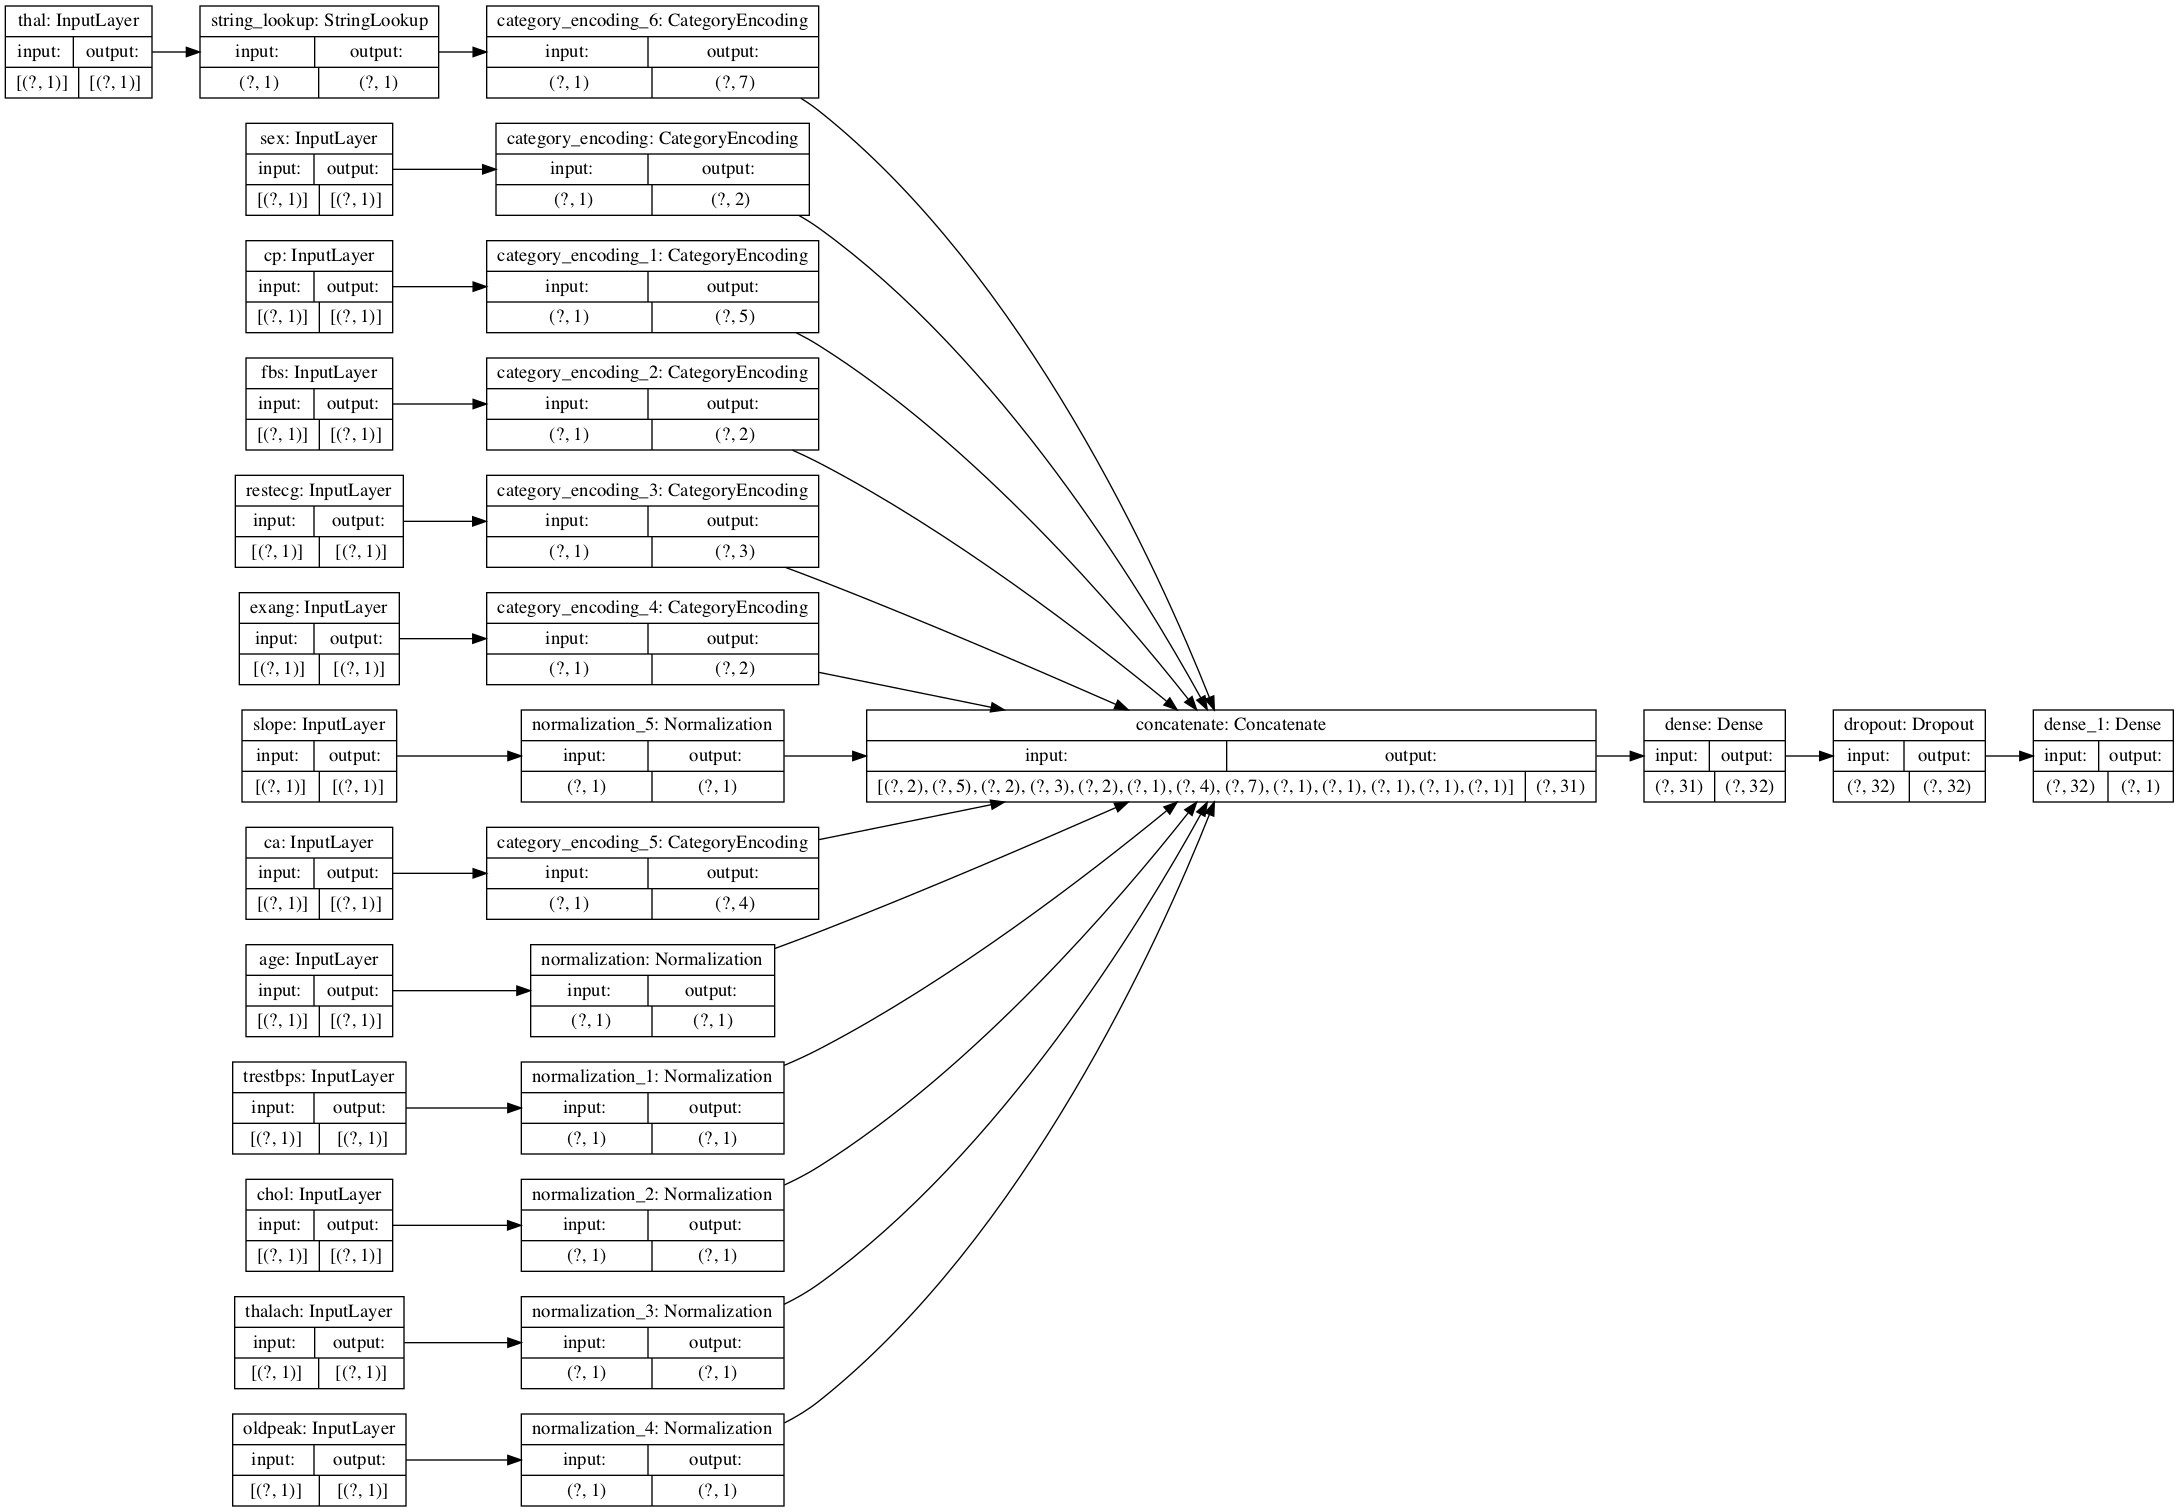

In [9]:
#Let's visualize our connectivity graph:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [25]:
#Train the model
model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
8/8 [==============================] - 0s 41ms/step - loss: 0.6328 - accuracy: 0.6777 - val_loss: 0.5652 - val_accuracy: 0.6885
Epoch 2/30
8/8 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6405 - val_loss: 0.5207 - val_accuracy: 0.7541
Epoch 3/30
8/8 [==============================] - 0s 5ms/step - loss: 0.5615 - accuracy: 0.7438 - val_loss: 0.4879 - val_accuracy: 0.7705
Epoch 4/30
8/8 [==============================] - 0s 4ms/step - loss: 0.5284 - accuracy: 0.7107 - val_loss: 0.4638 - val_accuracy: 0.7869
Epoch 5/30
8/8 [==============================] - 0s 5ms/step - loss: 0.5078 - accuracy: 0.7562 - val_loss: 0.4465 - val_accuracy: 0.7869
Epoch 6/30
8/8 [==============================] - 0s 5ms/step - loss: 0.4937 - accuracy: 0.7603 - val_loss: 0.4338 - val_accuracy: 0.7705
Epoch 7/30
8/8 [==============================] - 0s 5ms/step - loss: 0.4893 - accuracy: 0.7231 - val_loss: 0.4237 - val_accuracy: 0.7705
Epoch 8/30
8/8 [=================

Inference on new data
To get a prediction for a new sample, you can simply call model.predict(). There are just two things you need to do:

wrap scalars into a list so as to have a batch dimension (models only process batches of data, not single samples)
Call convert_to_tensor on each feature

In [26]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
model.predict(input_dict)

array([[0.4487988]], dtype=float32)

In [19]:
#This particular patient had a 44% probability of having a heart disease, as evaluated by our model.